# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

import pathlib

In [2]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = 2*np.array((8,6))
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) /  "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [4]:
HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

In [5]:
matches_filename = pathlib.Path(dwarfz.data_dir_default)  / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [6]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [7]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [8]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [9]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    pathlib.Path(dwarfz.data_dir_default)/ "HSC_matched_to_FRANKENZ.sqlite"),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [10]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Compare target galaxies to contaminant galaxies

In [11]:
z_target  = .10 
dz_target = .05
z_target_low = z_target - dz_target
z_target_high = z_target + dz_target

mask_target = (combined.photo_z > z_target_low) & (combined.photo_z < z_target_high)
print("num target galaxies: ", mask_target.sum())

target_line_wavelength = 656.3 # H alpha in nm
contaminant_line_wavelength = 500.7 # O_III in nm

z_contaminant_low =  (1+z_target_low )*(target_line_wavelength / contaminant_line_wavelength) - 1
z_contaminant_high = (1+z_target_high)*(target_line_wavelength / contaminant_line_wavelength) - 1

print("z_contaminant range: [{:.2f}, {:.2f}]".format(z_contaminant_low, z_contaminant_high))

mask_contaminant = (combined.photo_z > z_contaminant_low) & (combined.photo_z < z_contaminant_high)
print("num contaminant galaxies: ", mask_contaminant.sum())


num target galaxies:  6819
z_contaminant range: [0.38, 0.51]
num contaminant galaxies:  20120


Text(0, 0.5, '$\\log_{10} M_\\star / M_\\odot$')

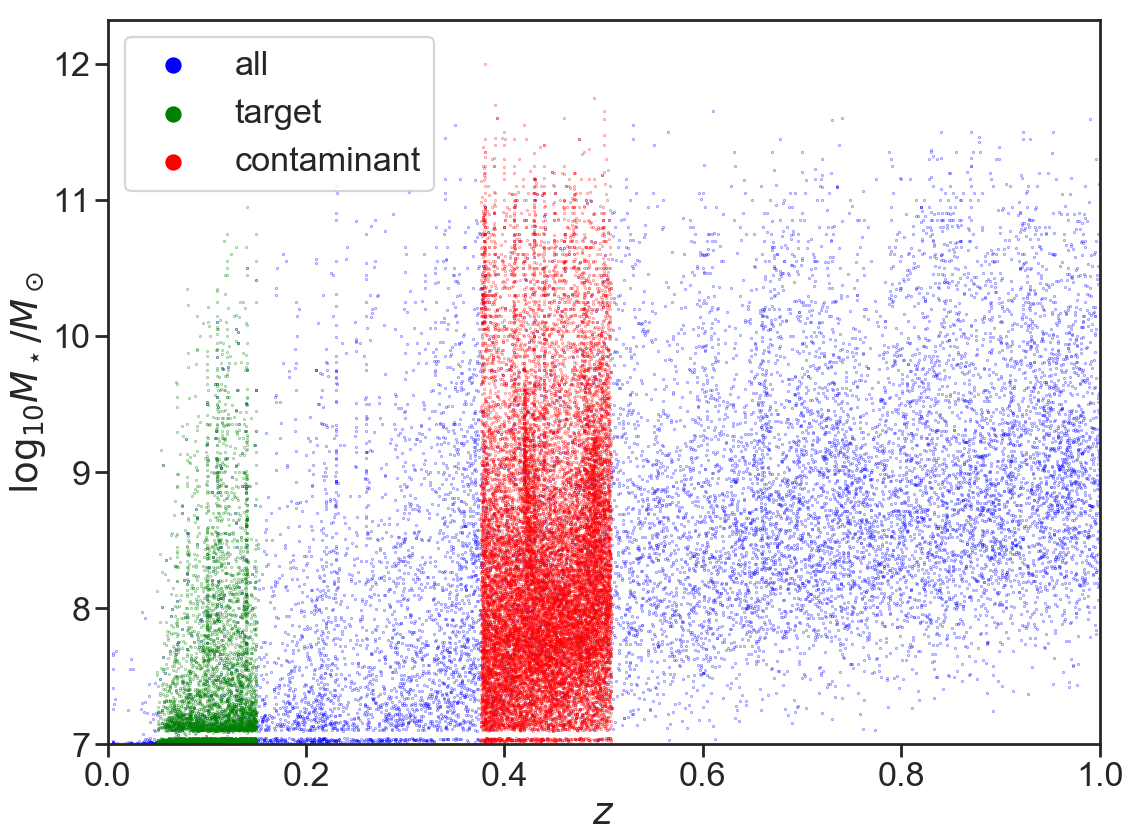

In [12]:
downsample_factor = 10
mask_downsample = (combined.index % downsample_factor == 0)

plt.scatter(combined.photo_z[mask_downsample], 
            combined.log_mass[mask_downsample],
            color="blue",
            label="all",
            s = .1,
           )

plt.scatter(combined[mask_target].photo_z, 
            combined[mask_target].log_mass,
            color="green",
            label="target",
            s = .1,
           )

plt.scatter(combined[mask_contaminant].photo_z, 
            combined[mask_contaminant].log_mass,
            color="red",
            label="contaminant",
            s = .1,
           )

plt.legend(loc="best", markerscale=40)

plt.xlim(0, 1)
plt.ylim(bottom=7)

plt.xlabel(r"$z$")
plt.ylabel(r"$\log_{10} M_\star / M_\odot$")